# VS of DrugBank by QSAR models of SARS-CoV

## Importing modules and functions        
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import _pickle as cPickle
import gzip

from stats import *

from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold

def warn(*args, **kwargs):
    pass
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import screening data

In [2]:
# Set file path and format
file = '../datasets/curated_data/drugbank.sdf.gz'

# Read SDF
sdfInfo = dict(molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo);
#print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')

RDKit ERROR: [17:35:37] Explicit valence for atom # 36 N, 5, is greater than permitted
RDKit ERROR: [17:35:37] ERROR: Could not sanitize molecule ending on line 660489


Kept data:  (9614, 6)


,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,ID,Mol
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,,

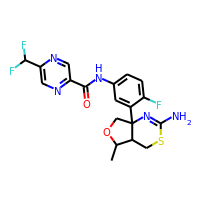


 Problematic structures: 
 []


In [3]:
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

### Calculate Morgan Fingerprints

In [4]:
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality=False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

X_vs = moldf.Mol.apply(calcfp)
X_vs.shape

(9614, 2048)

# Virtual screening Morgan

##### Load the model

In [5]:
with gzip.open('../model/sars-cov-3clpro-morgan_RF_ad_balanced.pgz', 'rb') as f:
    model = cPickle.load(f)

##### Predict molecules

In [6]:
%%time
ad_threshold = 0.70

y_pred = model.predict(X_vs)
confidence = model.predict_proba(X_vs)
confidence = np.amax(confidence, axis=1).round(2)
ad = confidence >= ad_threshold

pred = pd.DataFrame({'Prediction': y_pred, 'AD': ad, 'Confidence': confidence}, index=None)
pred.AD[pred.AD == False] = np.nan
pred.AD[pred.AD == True] = pred.Prediction.astype(int)

CPU times: user 1.02 s, sys: 86.6 ms, total: 1.11 s
Wall time: 509 ms


In [7]:
pred_ad = pred.dropna().astype(int)
coverage_ad = len(pred_ad) * 100 / len(pred)

print('VS pred: %s' % Counter(pred.Prediction))
print('VS pred AD: %s' % Counter(pred_ad.Prediction))
print('Coverage of AD: %.2f%%' % coverage_ad)

VS pred: Counter({0: 9546, 1: 68})
VS pred AD: Counter({0: 5757})
Coverage of AD: 59.88%


###  Visualize predictions

,GENERIC_NAME,DRUGBANK_ID,DRUG_GROUPS,InChIKey,ID,Mol,Prediction,AD,Confidence
0,Elenbecestat,DB15391,investigational,AACUJFVOHGRMTR-DPXNYUHVSA-N,,,Inactive,NaN,0.57
1,Eticlopride,DB15492,experimental,AADCDMQTJNYOSS-LBPRGKRZSA-N,,,Inactive,NaN,0.69
2,Pirnabine,DB12840,investigational,AADNQNOXNWEYHS-UHFFFAOYNA-N,,,Inactive,Inactive,0.75
3,Dianhydrogalactitol,DB12873,investigational,AAFJXZWCNVJTMK-GUCUJZIJSA-N,,,Inactive,Inactive,0.80
4,"N-1,10-phenanthrolin-5-ylacetamide",DB08440,experimental,AAJXINSCZMZERD-UHFFFAOYSA-N,,,Inactive,Inactive,0.71

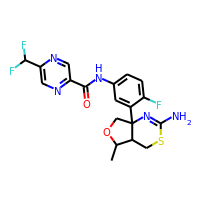
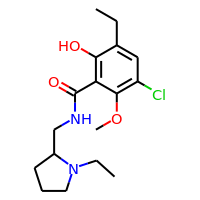
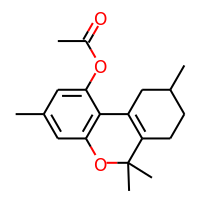
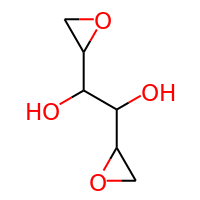
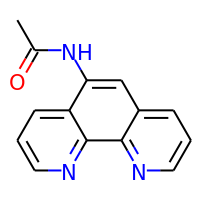

In [8]:
predictions = pd.concat([moldf, pred], axis=1)
for col in ['Prediction', 'AD']:
    predictions[col].replace(0,'Inactive',inplace=True)
    predictions[col].replace(1,'Active',inplace=True)
predictions.head()

## Export SDF and Excel

In [9]:
predictions.drop(columns='Mol', inplace=True)
with pd.ExcelWriter('../datasets/screened_compounds/drugbank_hits_qsar_morgan.xlsx') as writer:
    predictions.to_excel(writer, sheet_name='morgan', index=False)